## data exploration - county
* distribution of candidate features - bar plot
* valid range for candidate features - boxplot
* general trends - line chart
* correlation - scatter plot

### distribution
#### redfin_properties
* property distribution over city/zip (histogram)
* property construction over years based on 'year_built'

#### redfin_transactions
* transaction count distribution over years/month (histogram)
* 1-year transaction distribution over city/zip

#### question - correlation btw unit price and features
* 1-year sold price distribution (histogram)
* 1-year distribution of unit-price over city (violin)
* 1-year unit price correlation with direct features (bar)

#### appreciation
* plot avg unit price trend over years to identify uptrend/downtrend cycles
* explore avg unit price trend in uptrend/downtrend/long-term for each city/zip
* explore avg unit price trend in uptrend/downtrend/long-term for each price range

In [2]:
import pandas as pd
import os,sys
from sqlalchemy import create_engine
import numpy as np
color = sns.color_palette()

cwd = os.getcwd()
lib_path = os.path.abspath(os.path.join(cwd, 'lib'))
sys.path.append(lib_path)
from plot_utils import *

ServerName = "localhost"
Database = "sdra"

# Create the connection
engine = create_engine('postgresql://postgres:@' + ServerName + ':5432/' + Database)

### dataset basics

In [2]:
# property
sql = '''
SELECT p.*, a.str_no, a.street, a.city, a.zip
FROM property_features p, property_addresses a
WHERE p.pin = a.pin
'''
df_property = pd.read_sql_query(sql, engine)
df_property.shape

(709325, 17)

In [3]:
# total transactions
sql = '''SELECT t.* FROM transactions t'''
df_transaction = pd.read_sql_query(sql, engine)
print("total transaction event:", df_transaction.shape)

total transaction event: (2042059, 4)


In [4]:
# limit event, date
# remove duplicate by limit source to 'Public Records'
# SELECT rp.redfin_id, rp.number, rp.street, rp.city, rp.zip, rt.event, rt.date, rt.price, rp.sqft, rp.sqft_est, rp.lot_size_sqft, rp.lot_size_info, rp.lot_size_acre, rp.price, rp.price_per_sqft, rp.year_built, rp.url
sql_transaction_1year = '''
SELECT a.str_no, a.street, a.city, a.zip, t.date, t.sold_price, p.*
FROM property_features p, transactions t, property_addresses a
WHERE p.pin = a.pin AND p.pin = t.pin
  AND t.date between '2016-10-01' AND '2017-10-01'
ORDER by t.date DESC
'''
df_1year = pd.read_sql_query(sql_transaction_1year, engine)
df_1year['unit_price'] = df_1year['sold_price'] / df_1year['sqft']
df_1year['date'] = pd.to_datetime(df_1year['date'])
df_1year['sold_year'], df_1year['sold_month'] = df_1year['date'].dt.year, df_1year['date'].dt.month
print(df_1year.shape)
df_1year[:3]

(37938, 22)


,str_no,street,city,zip,date,sold_price,pin,land_use_code,land_use_subcode,year_built,...,num_bath,par_addition_area,num_units,par_current_land,par_current_imps,par_personal_property,par_tax_status,unit_price,sold_year,sold_month
0,9739,MESA SPRINGS,SAN DIEGO,92126,2017-09-27,358000,3413302440,1,17,1985.0,...,20.0,0,1,163200,109140,0,T,343.900096,2017,9
1,345,FLOWER HILL,SAN MARCOS,92078,2017-09-27,660000,2204734500,1,11,2004.0,...,40.0,0,1,183000,467000,0,T,208.070618,2017,9
2,8686,VIA MALLORCA,LA JOLLA,92037,2017-09-27,359000,3468020306,1,17,2000.0,...,10.0,0,1,162337,73591,0,T,519.536903,2017,9


In [5]:
# all transactions
sql = '''
SELECT a.str_no, a.street, a.city, a.zip, t.date, t.sold_price, p.*
FROM property_features p, transactions t, property_addresses a
WHERE p.pin = t.pin and p.pin = a.pin
ORDER by t.date DESC
'''
df_all = pd.read_sql_query(sql, engine)
df_all['unit_price'] = df_all['sold_price'] / df_all['sqft']
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['sold_year'], df_all['sold_month'] = df_all['date'].dt.year, df_all['date'].dt.month
print(df_all.shape)
df_all[:3]

(1543380, 22)


,str_no,street,city,zip,date,sold_price,pin,land_use_code,land_use_subcode,year_built,...,num_bath,par_addition_area,num_units,par_current_land,par_current_imps,par_personal_property,par_tax_status,unit_price,sold_year,sold_month
0,1113,HILLTOP,CHULA VISTA,91911,2017-10-24,447000,5754330300,1,11,1955.0,...,15.0,0,1,133145,110954,0,T,399.107143,2017,10
1,3305,GENOA,OCEANSIDE,92056,2017-10-19,397000,1657014212,1,17,1993.0,...,20.0,0,1,234000,91000,0,T,390.748031,2017,10
2,5725,BEAUMONT,LA JOLLA,92037,2017-09-27,1660000,3573820800,1,11,1941.0,...,20.0,593,1,371607,196111,0,T,1031.055901,2017,9


In [6]:
df_all_valid= df_all[(df_all['sqft']!=0) & (df_all['sold_price']>0)]
print(df_all.shape)
print(df_all_valid.shape)

(1543380, 22)
(1543380, 22)


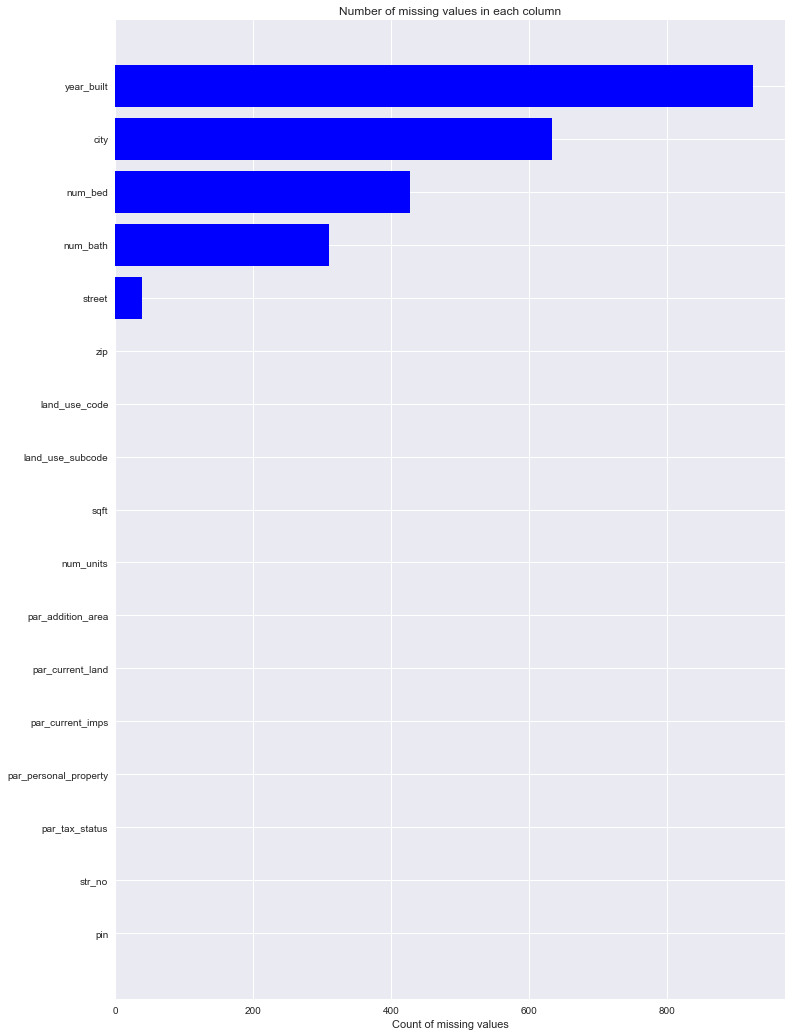

In [7]:
# check the missing values
# for integer columns replace 0 with NaN
#int_columns = ['number', 'num_bed', 'price', 'num_bath', 'price_per_sqft', 'sqft_est', 'sqft']
#df_property[int_columns] = df_property[int_columns].replace(0, np.nan)

missing_df = df_property.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

missing_df = missing_df.sort_values(by='missing_count')

In [9]:
def plot_histogram(df, index_column, hist_column, title=None):
    if not title: title = "histgram " + hist_column
    df_indexed = df
    if index_column: df_indexed = df.set_index(index_column)
    ax = df_indexed[hist_column].plot(kind='bar', title = title, figsize=(15, 8), legend=True, fontsize=12, secondary_y=True)
    ax.set_xlabel(index_column, fontsize=12)
    ax.set_ylabel(hist_column, fontsize=12)
    plt.show()

def plot_histogram_group(df, index_column, hist_columns):
    fig, ax = plt.subplots(len(hist_columns), 1, figsize=(15,10))
    df_indexed = df.set_index(index_column)
    for i,col in enumerate(hist_columns):
        df_indexed[col].plot(ax=ax[i], kind='bar', title ="histgram " + col, legend=True, fontsize=12)
        ax[i].set_xlabel(index_column, fontsize=12)
        ax[i].set_ylabel(col, fontsize=12)
    plt.show()

def plot_histogram_group_scaled(df, index_column, hist_columns, title=None):
    plt.figure(figsize=(15, 6))
    fig, ax = plt.subplots()
    df_scaled = df.set_index(index_column)
    legends = hist_columns.copy()
    for i,col in enumerate(hist_columns):
        legends[i] += ' - max:' + str(df_scaled[col].max())
        df_scaled[col] /= float(df_scaled[col].max())
        
    df_scaled[hist_columns].plot.bar(figsize=(10,6), title=title, ax=ax)
    ax.legend(legends);
    plt.show()
    
def plot_curve(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

def plot_correlation(df_in, target, columns):
    #mean_values = df_in.mean(axis=0)
    #df_in_new = df_in.fillna(mean_values)
    labels = []
    values = []
    for col in columns:
        labels.append(col)
        values.append(np.corrcoef(df_in[col].values, df_in[target].values)[0,1])
    df_corr = pd.DataFrame({'col_labels':labels, 'corr_values':values})
    df_corr = df_corr.sort_values(by='corr_values')

    ind = np.arange(len(labels))
    width, height = 12, 0.3 * len(columns)
    fig, ax = plt.subplots(figsize=(width,height))
    rects = ax.barh(ind, np.array(df_corr.corr_values.values), color='b')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_corr.col_labels.values, rotation='horizontal')
    ax.set_xlabel("Correlation coefficient")
    ax.set_title("Correlation coefficient of the variables")
    plt.show()
    return df_corr

def plot_joint_dist(df_in, col, target, uc=100, lc=0, ut=100, lt=0):
    ulimit = np.percentile(df_in[col].values, uc)
    llimit = np.percentile(df_in[col].values, lc)
    df1 = df_in[df_in[col]<=ulimit]
    df1 = df1[df1[col]>=llimit]
    
    ulimit = np.percentile(df_in[target].values, ut)
    llimit = np.percentile(df_in[target].values, lt)
    df2 = df1[df1[target]<=ulimit]
    df2 = df2[df2[target]>=llimit]

    plt.figure(figsize=(10,10))
    sns.jointplot(x=df2[col].values, y=df2[target].values, size=10, color=color[1])
    plt.ylabel(target, fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.title(col + ' Vs ' + target, fontsize=15)
    plt.show()
    
def plot_violin(df, x, y, order=None, title=None):
    plt.figure(figsize=(18,8))
    sns.violinplot(x=x, y=y, data=df, order=order)
    plt.xlabel(x, fontsize=15, rotation='vertical')
    plt.xticks(rotation=90)       
    plt.ylabel(y, fontsize=15)
    if not title: title = "dist of {} per {}".format(y, x)
    plt.title(title)
    plt.show()

### property distributions
* over city/zip
* city 'San Diego' dominate the property count
* construction over years
* Can't make significance due to missing value of year_built (119826 vs 602266 missing)

In [17]:
df_property[:2]

,pin,land_use_code,land_use_subcode,sqft,num_bed,num_bath,par_addition_area,par_units,par_current_land,par_current_imps,par_personal_property,par_tax_status,str_no,street,city,zip
0,1011102800,1,19,0,None,None,0,0,3527,0,0,T,0,TENAJA,FALLBROOK,92028
1,1012107700,1,11,3309,4,30,0,2,389612,1295730,438912,T,41400,DE LUZ,FALLBROOK,92028


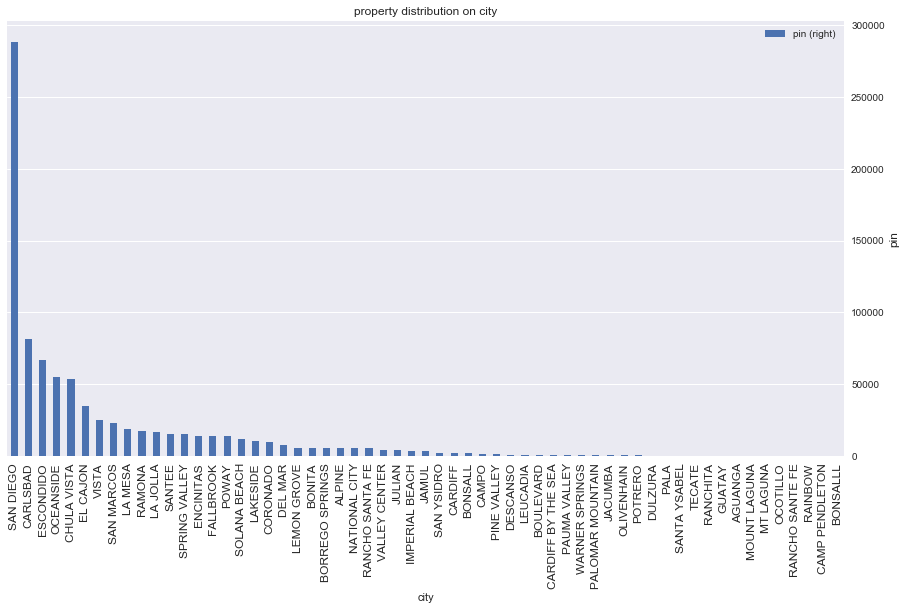

In [19]:
# distribution of all properties over region
prop_dist_on_city = df_property.groupby(by=['city']).count().sort_values(by='pin', ascending=False)
plot_histogram(prop_dist_on_city, None, 'pin', title='property distribution on city')

In [14]:
print(df_property.shape)
df_property.fillna(0).groupby('year_built').count().pin

(1047224, 18)


KeyError: 'year_built'

In [ ]:
# distribution of construction
print("valid year_built:",df_property[(df_property['year_built'] >= 1920) & (df_property['year_built'] <= 2020)].shape)
prop_dist_on_year = df_property[(df_property['year_built'] >= 1920) & (df_property['year_built'] <= 2020)].groupby(by=['year_built']).count()
plot_histogram(prop_dist_on_year, None, 'redfin_id', title='property distribution over years')

## transaction histogram


### transaction(market hotness)
* low volumn & short sale time: demand > supply (hot market)
* high volumn & short sale time: demand = supply (crazy market)
* high volumn & long sale time: demand < supply (possible?)
* low volumn & long sale time: demand < supply (cold market)

### transaction distribution
* over time (yearly/monthly)
* over district (zip, city)
* over price

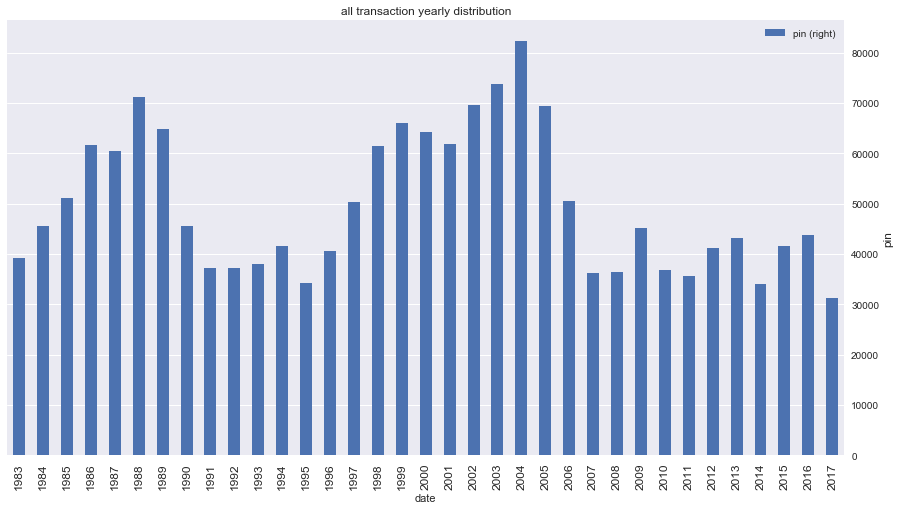

In [20]:
df_sold_indexed = df_all.set_index(pd.DatetimeIndex(df_all['date']))
df_over_year = df_all.groupby(df_sold_indexed.index.year).count()
plot_histogram(df_over_year, None, 'pin', title='all transaction yearly distribution')

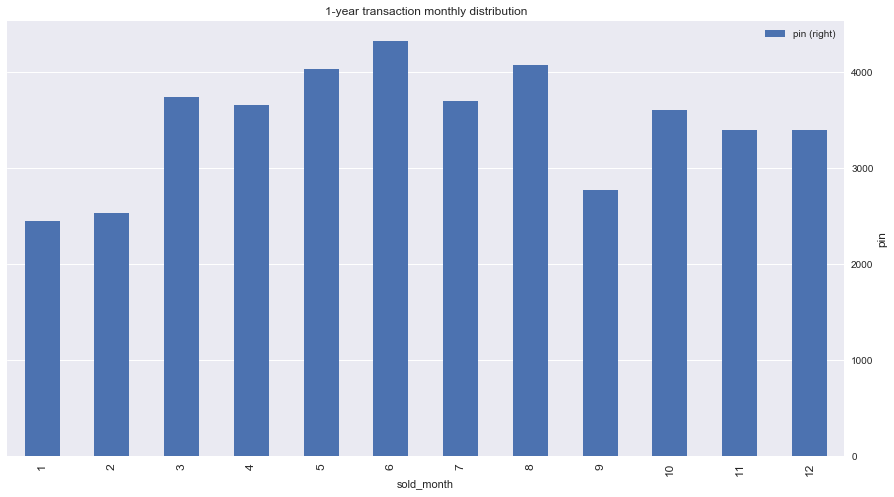

In [21]:
#df_1year_indexed = df_1year.set_index(pd.DatetimeIndex(df_1year['date']))
df_1year_over_month = df_1year.groupby(['sold_month']).count()
plot_histogram(df_1year_over_month, None, 'pin', title='1-year transaction monthly distribution')

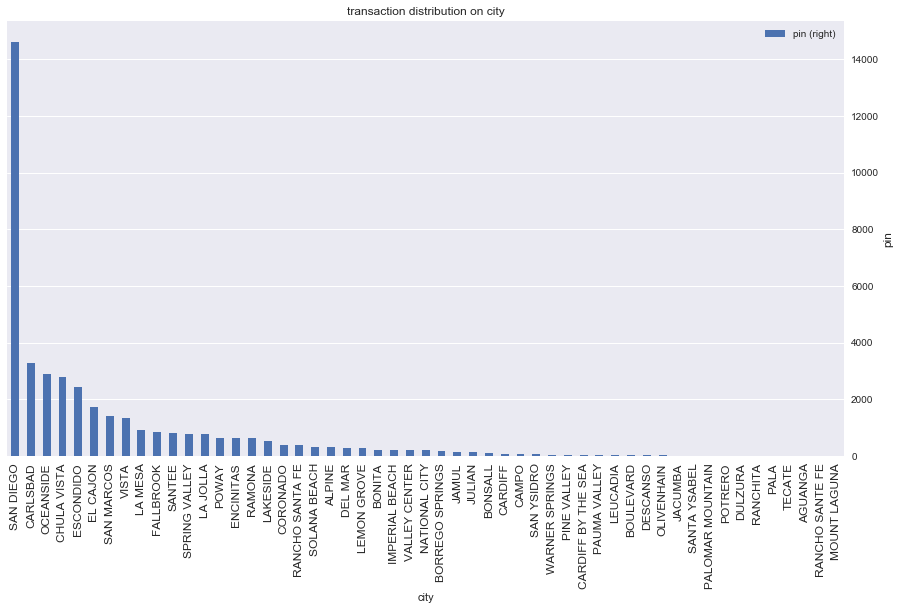

In [22]:
trans_1year_on_city = df_1year.groupby(by=['city']).count().sort_values(by='pin', ascending=False)
plot_histogram(trans_1year_on_city, None, 'pin', title='transaction distribution on city')

In [23]:
turnover = trans_1year_on_city['pin'] / prop_dist_on_city['pin']
turnover.fillna(0)

city
AGUANGA               0.047619
ALPINE                0.055955
BONITA                0.039877
BONSALL               0.061303
BONSALLL              0.000000
BORREGO SPRINGS       0.032832
BOULEVARD             0.037534
CAMP PENDLETON        0.000000
CAMPO                 0.046367
CARDIFF               0.041089
CARDIFF BY THE SEA    0.055637
CARLSBAD              0.040588
CHULA VISTA           0.051815
CORONADO              0.037872
DEL MAR               0.036180
DESCANSO              0.024561
DULZURA               0.019139
EL CAJON              0.050282
ENCINITAS             0.044647
ESCONDIDO             0.036460
FALLBROOK             0.060168
GUATAY                0.000000
IMPERIAL BEACH        0.058688
JACUMBA               0.028634
JAMUL                 0.043521
JULIAN                0.030377
LA JOLLA              0.046574
LA MESA               0.048395
LAKESIDE              0.050566
LEMON GROVE           0.048705
LEUCADIA              0.047745
MOUNT LAGUNA          0.025000
MT 

In [24]:
def get_hist_on_price(transaction, min_price, max_price, buckets, **kwargs):
    condition = ''
    if 'city' in kwargs:
        condition += "AND lower(city) = '{}'".format(kwargs['city'])
    if 'zip' in kwargs:
        condition += "AND zip = '{}'".format(kwargs['zip'])
    sql = '''
    WITH 
    transactions AS (
    {}
    ),
    p_200 AS (
        -- (1) Filter out the property with price > $2,000,000
        SELECT *
        FROM transactions
        WHERE sold_price::decimal(10,1) between {} and {} {}
    ),
    p_minmax AS ( 
        -- (2) Find the min and max price of the current distribution
        SELECT MIN(sold_price::DECIMAL(10,1)) AS min_price,
           MAX(sold_price::DECIMAL(10,1)) AS max_price
        FROM p_200
    )
    -- (3) The data in the range min_price to max_price is divided into 10 + 1 buckets. Find the bucket to which the price of each product belongs to. And group them by buckets.
    SELECT WIDTH_BUCKET(sold_price::DECIMAL(10,1), min_price, max_price, {}) AS bucket,
          MIN(sold_price::DECIMAL(10,1)) as min_price, MAX(sold_price::DECIMAL(10,1)) as max_price,
          COUNT(1) AS count,
          SUM(sold_price) AS total_value
    FROM p_200, p_minmax
    GROUP BY bucket
    ORDER BY bucket
    '''.format(transaction, min_price, max_price, condition, buckets)
    if 'debug' in kwargs:
        print(sql)
    return pd.read_sql_query(sql, engine)

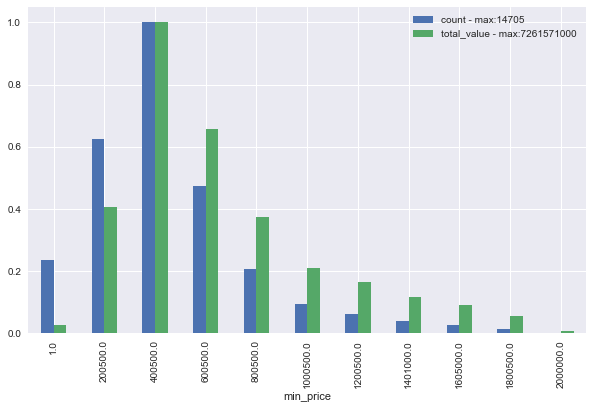

In [25]:
df = get_hist_on_price(sql_transaction_1year, 0, 2000000, 10)
#plot_histogram(df, 'min_price', 'count', 'transaction distribution on price')
plot_histogram_group_scaled(df, 'min_price', ['count', 'total_value'])

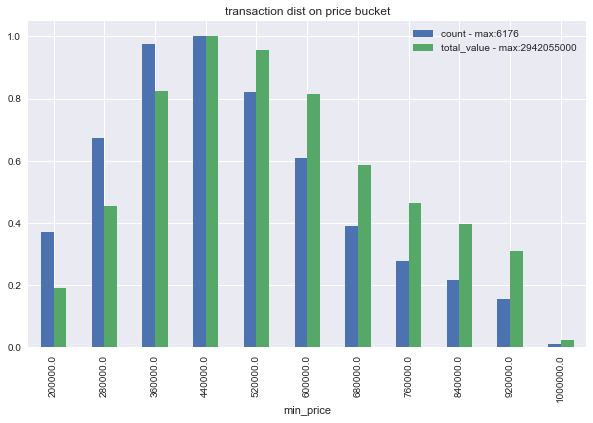

In [26]:
df = get_hist_on_price(sql_transaction_1year, 200000, 1000000, 10)
#plot_histogram(df, 'min_price', 'count', 'transaction distribution on price')
plot_histogram_group_scaled(df, 'min_price', ['count', 'total_value'], 'transaction dist on price bucket')

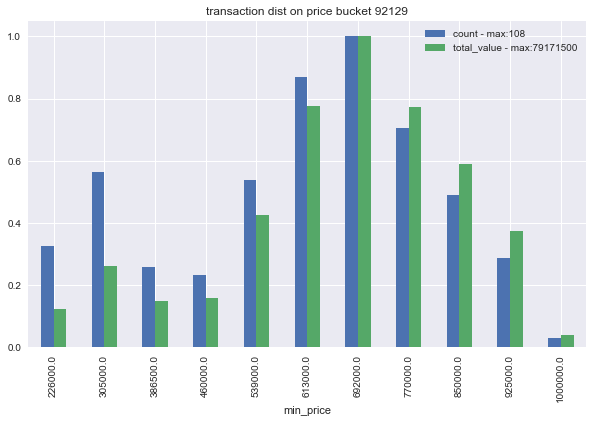

In [27]:
df = get_hist_on_price(sql_transaction_1year, 200000, 1000000, 10, city='san diego', zip='92129')
#plot_histogram(df, 'min_price', 'count', 'transaction distribution on price')
plot_histogram_group_scaled(df, 'min_price', ['count', 'total_value'], 'transaction dist on price bucket 92129')

## price/unit price
### unit_price trend - appreciation/depreciation over years
* segmented by area: city/zip
* segmented by price/sqft ranges

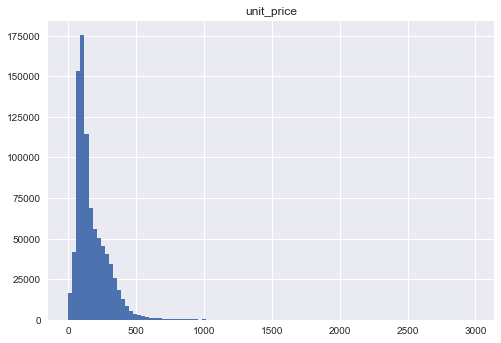

In [34]:
plt.figure()
df_all_valid[df_all_valid['unit_price']<3000].hist(column='unit_price',bins=100)
plt.show()

In [31]:
df_unit_price_trend = df_all_valid[(df_all_valid['unit_price']<1000)
                                  #&(df_all_valid['sold_year']>2000) 
                         ]

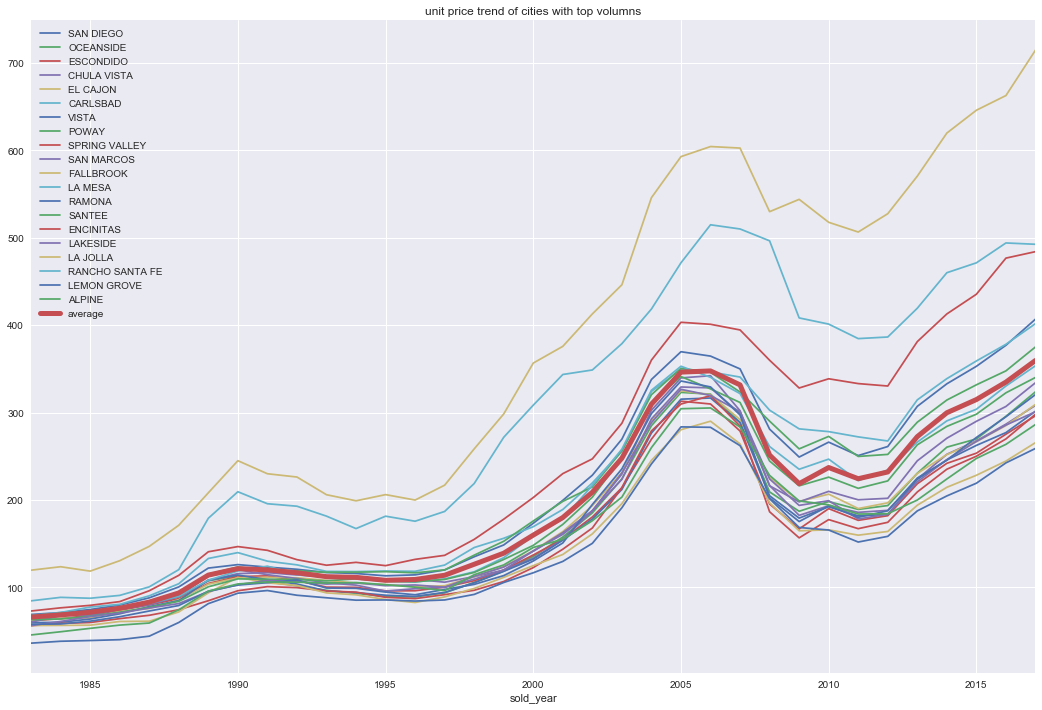

In [32]:
# segmented by area
zip_counts = df_all_valid['zip'].value_counts()
city_counts = df_all_valid['city'].value_counts()

unit_price = df_unit_price_trend.groupby(by=['city','sold_year'])['unit_price'].mean()
avg_unit_price = df_unit_price_trend.groupby(by=['sold_year'])['unit_price'].mean()

fig, ax = plt.subplots(figsize=(18,12))
top_cities = city_counts.index[0:20]
for city in top_cities:
    unit_price[city].plot(ax=ax, kind='line', label=city)
avg_unit_price.plot(ax=ax, kind='line', label='average', linewidth=5)
plt.legend(loc='best')
plt.title("unit price trend of cities with top volumns")
plt.show()

In [43]:
unit_price

zip    sold_year
       1984          13.266998
       1986          11.306314
       1987          38.836378
       1989          24.694663
       1996          32.560706
       1997          98.556375
       1998          38.338823
       1999         114.405080
       2000          57.817870
       2001          65.319124
       2002          58.967137
       2003          97.254005
       2004          73.729364
       2005          84.816100
       2007          62.472286
       2008          67.153104
       2010          47.894302
       2011         160.596026
       2012          64.814475
       2013          65.091926
       2014          70.780699
       2015         100.540060
       2016         201.328662
       2017         460.872918
90067  2003         473.962822
91607  1986          17.392652
       1991         333.281662
       1992         205.394512
       1995         200.162765
       2004         333.281662
                       ...    
92173  1999         10

In [42]:
unit_price[unit_price > 700]

zip    sold_year
92037  2017         714.761712
92097  1990         812.500000
       1999         820.833333
92118  2016         732.696410
       2017         716.818934
Name: unit_price, dtype: float64

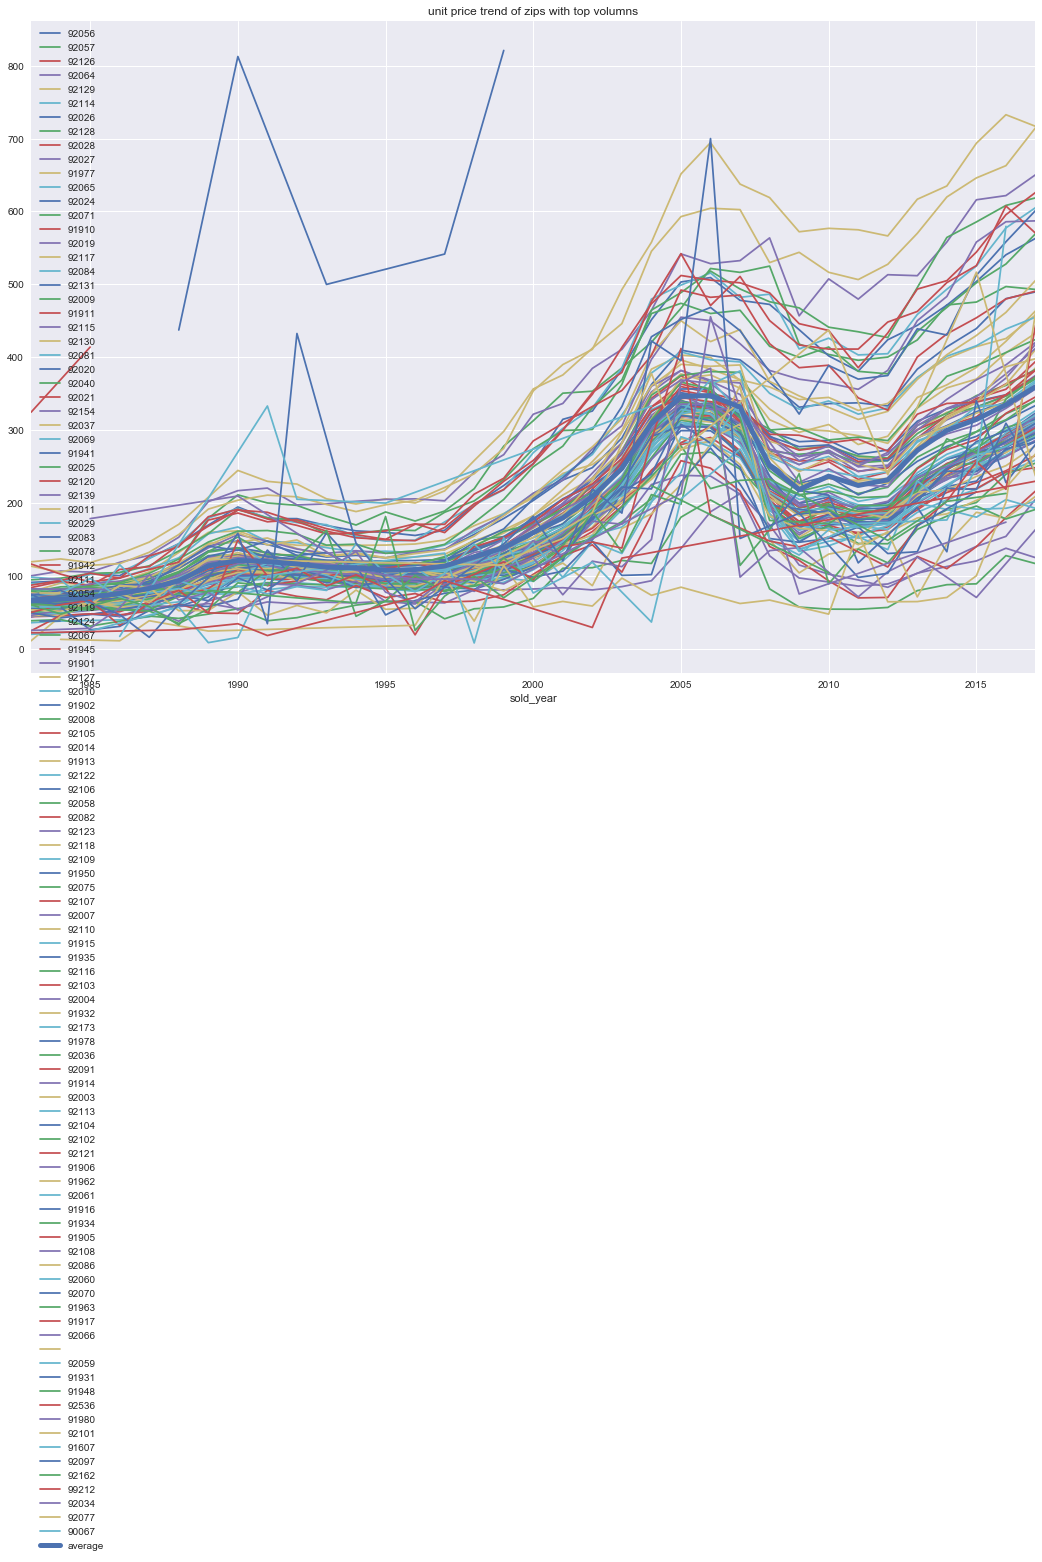

In [44]:
unit_price = df_unit_price_trend.groupby(by=['zip','sold_year'])['unit_price'].mean()
avg_unit_price = df_unit_price_trend.groupby(by=['sold_year'])['unit_price'].mean()

fig, ax = plt.subplots(figsize=(18,12))
#top_zips = zip_counts.index[0:30]
top_zips = zip_counts.index
for zip in top_zips:
    unit_price[zip].plot(ax=ax, kind='line', label=zip)
avg_unit_price.plot(ax=ax, kind='line', label='average', linewidth=5)
plt.legend(loc='best')
plt.title("unit price trend of zips with top volumns")
plt.show()

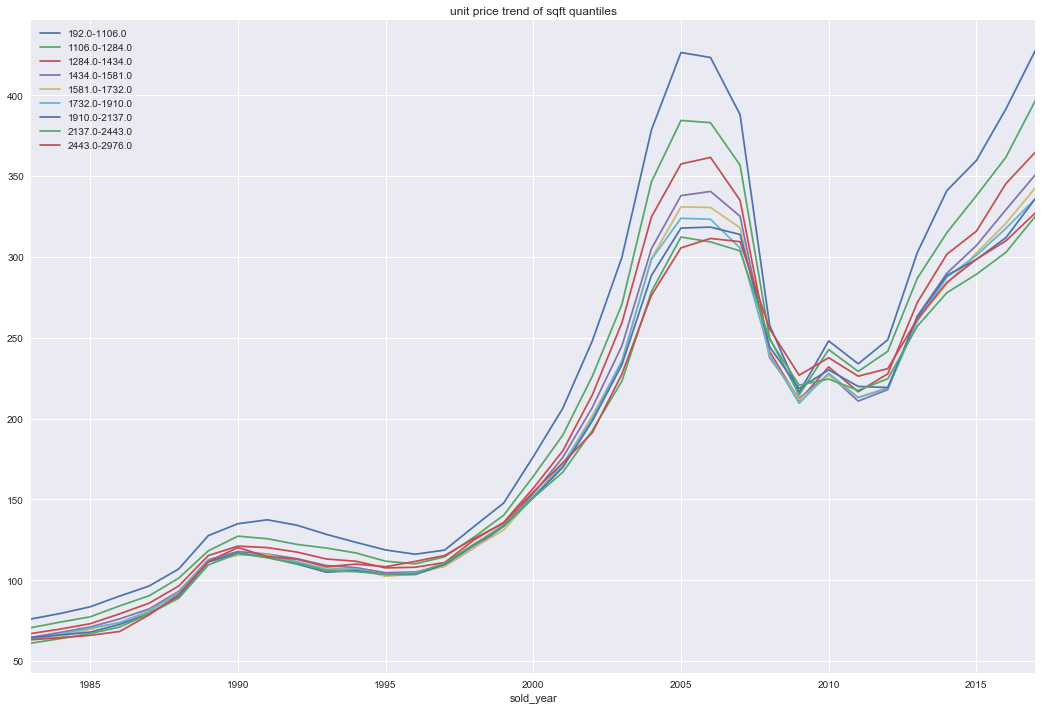

In [34]:
# segmented by sqft range
sqft_segments = [df_unit_price_trend['sqft'].quantile(0.1*i) for i in range(10)]

fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(sqft_segments)-1):
    sqft_b,sqft_e = sqft_segments[i], sqft_segments[i+1]
    df_sqft_seg = df_unit_price_trend[(df_unit_price_trend['sqft']>=sqft_b) & (df_unit_price_trend['sqft']<sqft_e)]
    #print(df_sqft_seg.shape)
    df_sqft_seg = df_sqft_seg.groupby(by=['sold_year'])['unit_price'].mean()
    df_sqft_seg.plot(ax=ax, kind='line', label="{}-{}".format(sqft_b,sqft_e))
plt.legend(loc='best')
plt.title("unit price trend of sqft quantiles")
plt.show()


### 1year price/unit_price 
* histogram
* among different zip/city
* among months

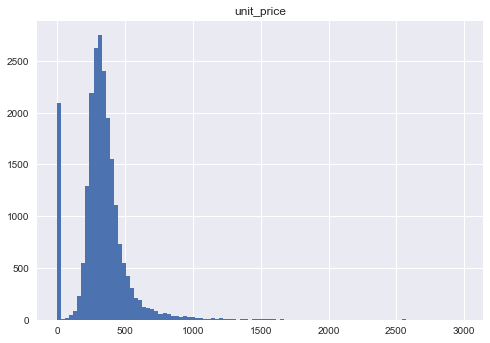

In [38]:
# distribution of 1year sales on unit_price
plt.figure()
df_1year[df_1year['unit_price']<3000].hist(column='unit_price',bins=100)
plt.show()

In [41]:
# filter out non-numeric columns and self correlation
cols = [col for col in df_1year.columns if col not in ['par_tax_rate_area', 'str_no', 'doc_num', 'unit_price', 'sold_price'] if df_1year[col].dtype in ['float64', 'int64']]
m_cols = cols + ['unit_price', 'sold_price']
mean_values = df_1year[m_cols].mean(axis=0)
# remove outliers
df_1year_valid = df_1year[(df_1year['unit_price']<1500) & (df_1year['unit_price']>0)]
print("1year valid data size:", df_1year_valid.shape)
print("1year total size:",df_1year.shape)

1year valid data size: (20162, 29)
1year total size: (22320, 29)


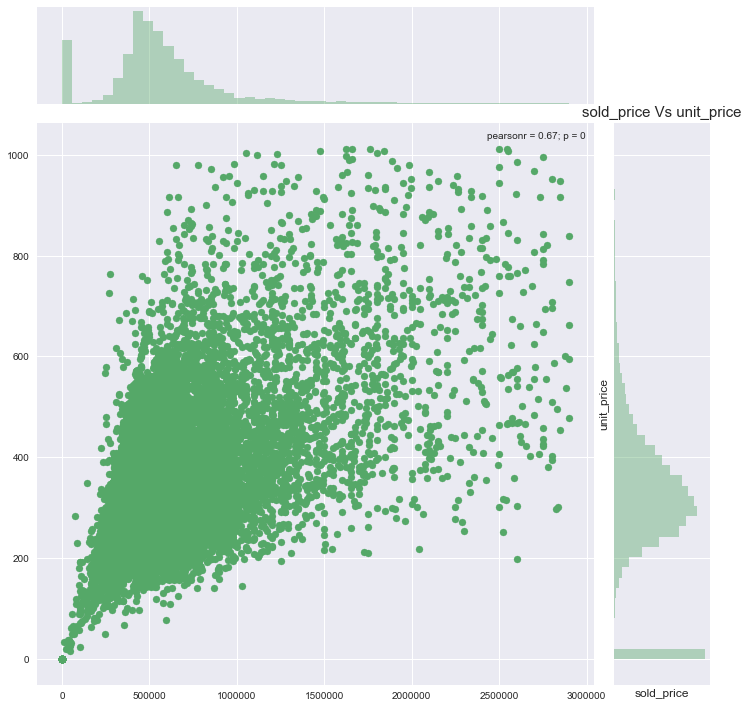

In [42]:
plot_joint_dist(df_1year_rectified, 'sold_price', 'unit_price', 99, 0, 99, 0)

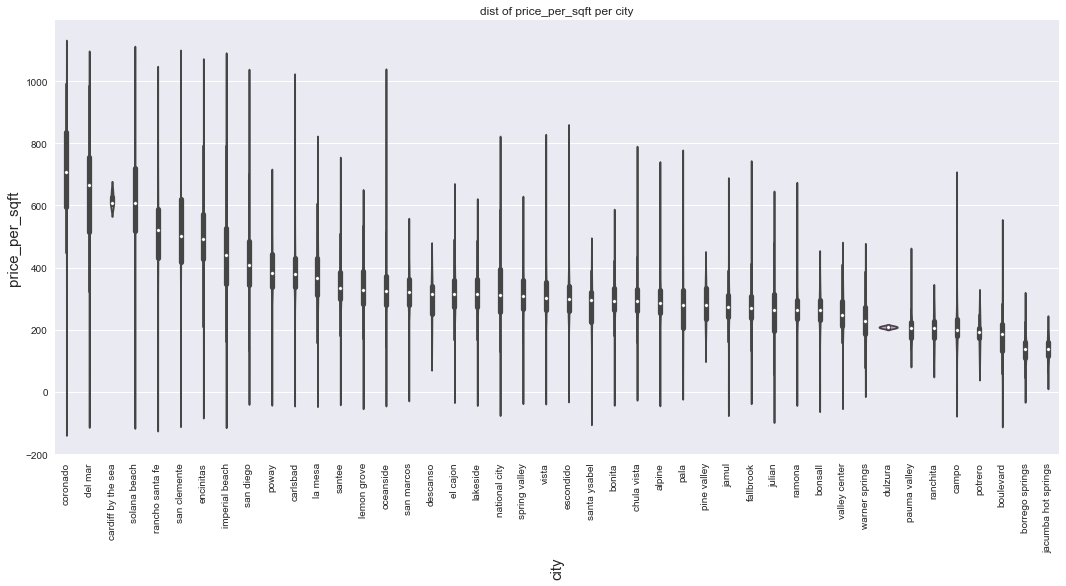

In [73]:
city_desc = df_1year_valid.groupby(df_1year_valid['city'].str.lower())["price_per_sqft"].median().sort_values(ascending=False).index
plot_violin(df_1year_valid, 'city', 'price_per_sqft', city_desc)

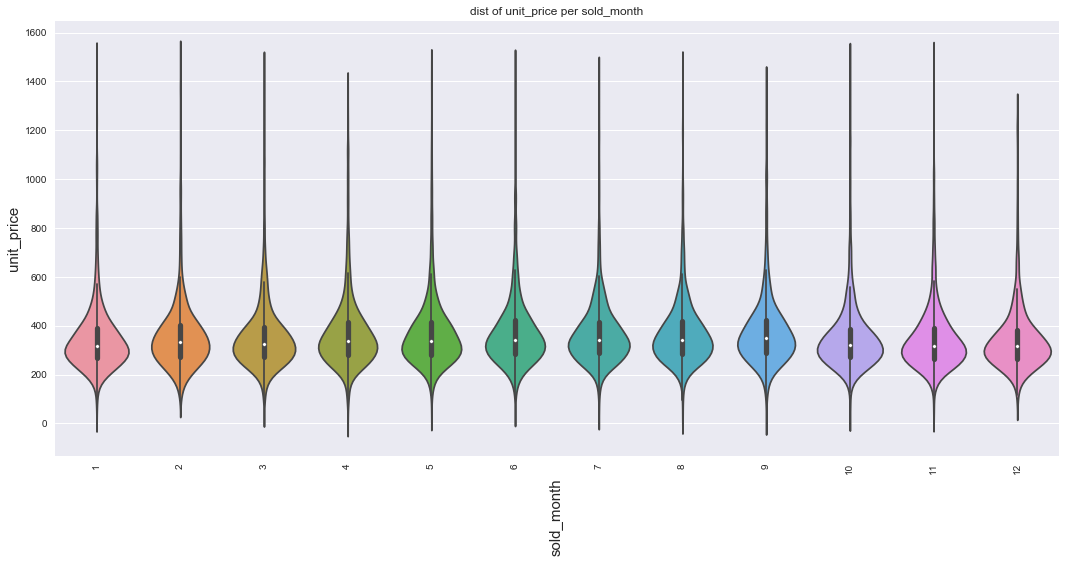

In [43]:
plot_violin(df_1year_valid, 'sold_month', 'unit_price')

### price/unit price correlation
* with geography: street, zip, city
* with transaction#
* with property characteristic: sqft, lot_size_sqft

In [54]:
# fill NA
df_1year_rectified = df_1year_valid[m_cols].fillna(mean_values)

In [63]:
df_1year[:10]

,par_parcel_number,par_tax_rate_area,par_land_use_code,par_total_lvg_area,par_bedrooms,par_bathroom,par_addition_area,par_garage_conversion,par_pool,par_view,...,srt_add,land,improvment,sqft,sold_price,address,date,unit_price,sold_year,sold_month
0,4551780700,8001,111,1689,3.0,20.0,0,N,N,None,...,VIACHA DR*\,74405,140073,1689,684000,11058 VIACHA DR ...,2017-09-27,404.973357,2017,9
1,3595200800,8118,111,1540,4.0,20.0,0,N,N,Y,...,COURSER AVE*\,13291,33440,1540,755000,03026 COURSER AVE ...,2017-09-27,490.259740,2017,9
2,1876510400,4312,111,2462,5.0,30.0,0,N,N,Y,...,SUMMIT CIRCLE GLN SOUTH*\,79685,195152,2462,0,02349 SUMMIT CIRCLE GLN SOUTH ...,2017-09-27,0.000000,2017,9
3,1084320300,75115,111,1318,3.0,20.0,0,N,None,N,...,LOS PADRES DR*\,81939,62908,1318,450000,04208 LOS PADRES DR ...,2017-09-27,341.426404,2017,9
4,3093511000,8012,111,1765,4.0,25.0,0,N,N,N,...,ANDASOL ST*\,73253,129417,1765,555000,07445 ANDASOL ST ...,2017-09-27,314.447592,2017,9
5,5816004600,8001,111,1425,3.0,25.0,0,N,N,None,...,BANNEKER DR*\,17969,44493,1425,370000,00890 BANNEKER DR ...,2017-09-27,259.649123,2017,9
6,2175014900,12238,111,1741,3.0,25.0,0,N,N,N,...,COUNTRYVIEW LN*\,89284,100444,1741,519500,01458 COUNTRYVIEW LN ...,2017-09-27,298.391729,2017,9
7,1234803700,75101,111,2556,3.0,25.0,0,N,N,Y,...,MONSERATE TER*\,100000,210000,2556,665000,03828 MONSERATE TER ...,2017-09-27,260.172144,2017,9
8,4803441100,15002,111,1385,3.0,10.0,368,Y,Y,Y,...,OLIVE ST*\,45000,87000,1385,425000,02756 OLIVE ST ...,2017-09-27,306.859206,2017,9
9,3195101000,8012,111,3517,4.0,30.0,0,None,Y,Y,...,SPRUCE RUN DR*\,88306,272088,3517,1100000,11748 SPRUCE RUN DR ...,2017-09-27,312.766562,2017,9


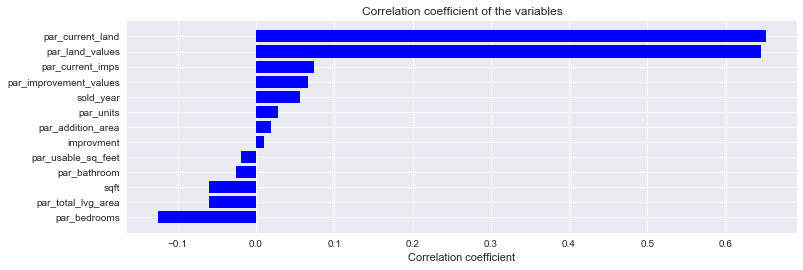

In [60]:
features = set(cols) - set(['sold_month', 'improvement', 'land', 'par_personal_property', 'par_land_use_code'])
#features = ['sqft']
df_corr_unit_price = plot_correlation(df_1year_rectified, 'unit_price', features)

In [61]:
corr_df_sel = df_corr_unit_price[(df_corr_unit_price['corr_values']>0.01) | (df_corr_unit_price['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
5,par_bedrooms,-0.125785
9,par_total_lvg_area,-0.060153
11,sqft,-0.060153
2,par_bathroom,-0.025615
0,par_usable_sq_feet,-0.019250
1,improvment,0.010583
7,par_addition_area,0.019400
8,par_units,0.028401
12,sold_year,0.056242
10,par_improvement_values,0.066861


### flipping house
* identification: multi transaction in short time with big price difference
* flipping house transaction window distribution
* flipping house gross gain/percentage distribution

In [211]:
# flip house, 2 sales in 1 year with appreciation either 1.02 or gross gain > 20K
def get_flip_house(df, appreciation=1.05, gain=20000):
    min_price = df.groupby(by='redfin_id')['sold_price'].transform('min').rename('min_price')
    max_price = df.groupby(by='redfin_id')['sold_price'].transform('max').rename('max_price')
    df_m = pd.concat([df, min_price, max_price], axis=1)
    mask = df_m.groupby(by='redfin_id')['redfin_id'].transform('count') > 1  # group size > 1 multi transaction
    mask &= (df_m['sold_price'] / df_m['min_price'] > 1) | (df_m['sold_price'] / df_m['max_price'] < 1)
    mask &= (df_m['max_price'] / df_m['min_price'] > appreciation) | (df_m['max_price'] - df_m['min_price'] > gain)
    return df_m[mask]
        
df_flip = get_flip_house(df_1year)

In [214]:
print(df_flip.shape)
df_flip[['redfin_id', 'number', 'street', 'city', 'zip', 'sold_price', 'event', 'source', 'date']][:10]

(2220, 90)


,redfin_id,number,street,city,zip,sold_price,event,source,date
20,5031025,10003,Beck Dr,santee,92071,649000,sold,Public Records,2017-03-09
21,5031025,10003,Beck Dr,santee,92071,450000,sold,Public Records,2016-12-02
115,5673564,10042,Diversion Dr,spring valley,91977,370000,sold,Public Records,2017-07-17
116,5673564,10042,Diversion Dr,spring valley,91977,70000,sold,Public Records,2017-06-16
203,5673586,10090,Diversion Dr,spring valley,91977,490000,sold,Public Records,2017-02-28
204,5673586,10090,Diversion Dr,spring valley,91977,300000,sold,Public Records,2016-12-02
297,3893269,1013,Glenwood Way,escondido,92026,443000,sold,Public Records,2016-12-12
298,3893269,1013,Glenwood Way,escondido,92026,310000,sold,Public Records,2016-09-26
339,6411541,10149,Peaceful Ct,santee,92071,285000,sold,Public Records,2017-06-20
340,6411541,10149,Peaceful Ct,santee,92071,217000,sold,Public Records,2017-01-20


In [215]:
df_flip[['number', 'street', 'city', 'zip', 'event', 'source', 'sold_price', 'appreciation']][:10]

,number,street,city,zip,event,source,sold_price,appreciation
20,10003,Beck Dr,santee,92071,sold,Public Records,649000,297.1%/yr
21,10003,Beck Dr,santee,92071,sold,Public Records,450000,5.7%/yr
115,10042,Diversion Dr,spring valley,91977,sold,Public Records,370000,">1,000%/yr"
116,10042,Diversion Dr,spring valley,91977,sold,Public Records,70000,None
203,10090,Diversion Dr,spring valley,91977,sold,Public Records,490000,661.4%/yr
204,10090,Diversion Dr,spring valley,91977,sold,Public Records,300000,None
297,1013,Glenwood Way,escondido,92026,sold,Public Records,443000,439.9%/yr
298,1013,Glenwood Way,escondido,92026,sold,Public Records,310000,None
339,10149,Peaceful Ct,santee,92071,sold,Public Records,285000,93.7%/yr
340,10149,Peaceful Ct,santee,92071,sold,Public Records,217000,1.9%/yr


In [ ]:
df_flip[]

## long-term
### price long-term trend
* avg unit price over time
* variance of unit price over time
### price long-term correlation
* with geography:
* with transaction#
* with economic environment (missing)

### profit for flipping trend
* avg profit/percentage over time
* variance of profit over time
### profit for flipping correlation

### price/unit price histogram
* distribution
* among different zip/city
* among months